In [1]:
import numpy as np
import torch
import torch.nn as nn
import os
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
from numpy import genfromtxt
import skimage
from skimage.transform import rotate
from skimage.util import random_noise
import copy
from copy import deepcopy
from matplotlib.font_manager import FontProperties
from sklearn.model_selection import train_test_split
from skimage import io
from collections import OrderedDict
from functools import partial
from keras.preprocessing import image
from keras.preprocessing.image import load_img

Using TensorFlow backend.


In [55]:
#drive/My Drive/fer2013.csv
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
while(True):
  filname = input()
  try:
    df=pd.read_csv(filname,names=names, na_filter=False)
    break
  except:
    print("Unexisting name of file: " + filname)
im=df['pixels']
df.head(10)

1
Unexisting name of file: 1
drive/My Drive/fer2013.csv


,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [0]:
def getData(filname):
    Y = []
    X = []
    train_set = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    
    for i in range(len(X)):
        train_set.append([X[i], Y[i]])
        
    return X, Y, train_set

In [5]:
X, Y, train = getData(filname)
num_class = len(set(Y))
pic_size = 48
chanels_num = 1
print(num_class)

7


In [0]:
N, D = X.shape
X = X.reshape(N, pic_size, pic_size, 1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [7]:
final_train_data = []
final_target_train = []
for i in tqdm(range(X_train.shape[0])):
    final_train_data.append(X_train[i])
    final_train_data.append(rotate(X_train[i], angle=45, mode = 'wrap'))
    final_train_data.append(np.fliplr(X_train[i]))
    final_train_data.append(np.flipud(X_train[i]))
    final_train_data.append(random_noise(X_train[i],var=0.2**2))
    for j in range(5):
        final_target_train.append(y_train[i])

100%|██████████| 32298/32298 [00:13<00:00, 2366.53it/s]


In [0]:
X_train = np.array(deepcopy(final_train_data))
y_train = np.array(deepcopy(final_target_train))

In [0]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).long()

In [78]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.features1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Conv2d(1, 64, kernel_size = (5, 5), padding=2),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        
        self.features2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Conv2d(64, 128, kernel_size = (3, 3), padding=1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )
        
        self._to_linear = 12 * 12 * 128

        self.features3 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self._to_linear, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace = True),
            nn.Dropout(0.2),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = torch.flatten(x, 1)
        x = self.features3(x)
        return x

net = SmallNet().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()
#SmallNet.h5
PATH = 0
while(not(PATH)):
  print("Input file name to save without .h5")
  PATH = input()
PATH += '.h5'
while(True):
  if (os.path.exists(PATH)):
    var = 'YES/no'
  else:
    var = 'yes/NO'
  print("Do you want to load NN from PATH? " + var)
  choice = input().upper()
  if ((choice == 'YES') or (choice == 'NO') or (not(choice))):
    if (choice == 'YES'):
      try:
        net.load_state_dict(torch.load(PATH))
        print("Choice YES, loaded")
        break
      except:
        print("Choice YES, Unexisting PATH: " + PATH)
        PATH = input("Enter new PATH:")
        PATH += '.h5'
    if (choice == 'NO'):
      print('Choice NO')
      break
    if (not(choice)):
      try:
        net.load_state_dict(torch.load(PATH))
        print("Default choice, loaded")
        break
      except:
        print("Default choice, PATH doesn't exist")
        break
  print('Unexisting choice')

Input file name to save without .h5
SmallNet
Do you want to load NN from PATH? YES/no
yEs
Choice YES, loaded


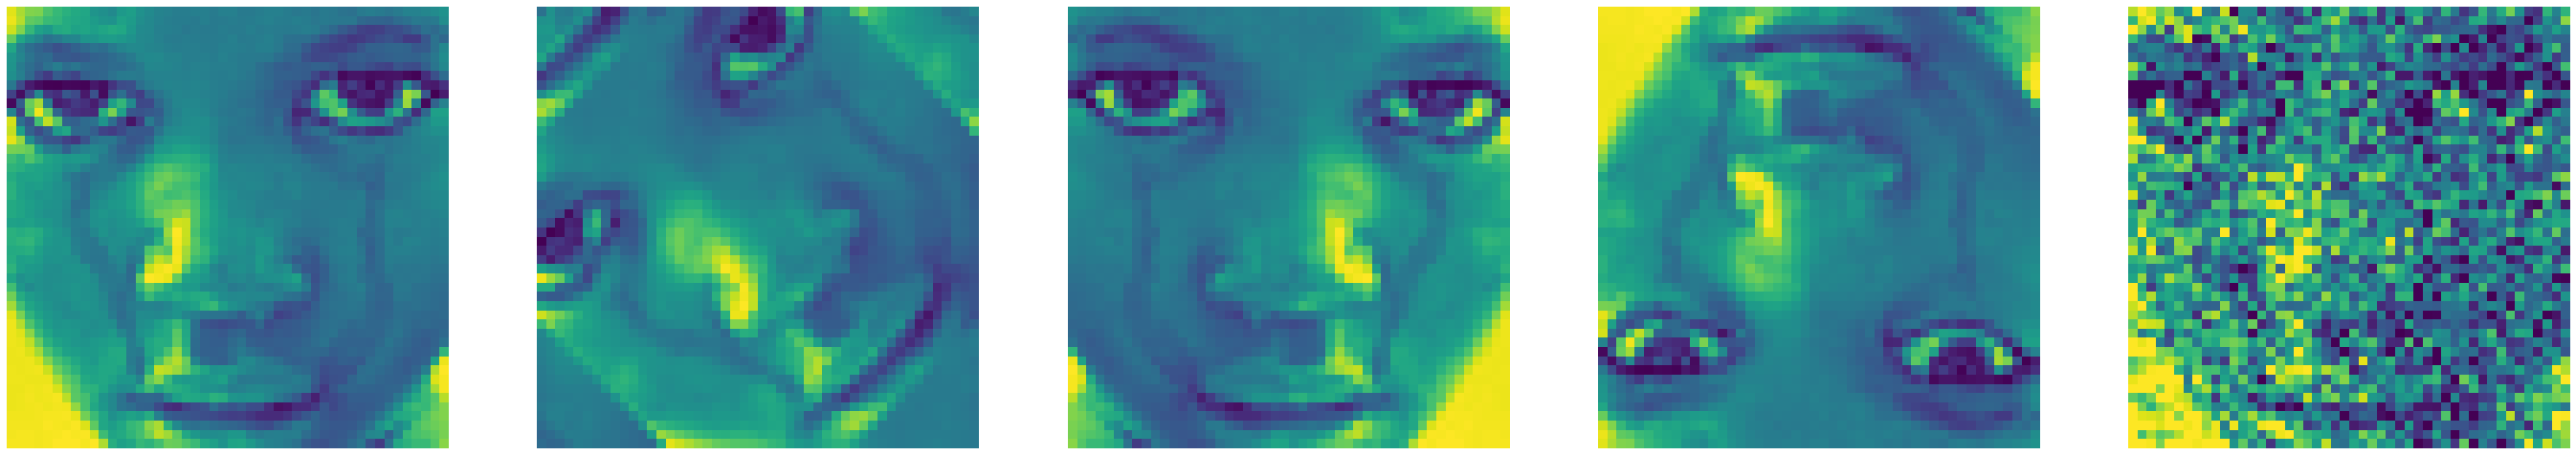

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(48,48))
for i in range(5):
    ax[i].imshow(X_train[i+5].view(48, 48))
    ax[i].axis('off')

In [12]:
EPOCHS = 1
batch_size = 100
train_acc = [0] * EPOCHS
train_loss = [0] * EPOCHS
test_acc = [0] * EPOCHS
test_loss = [0] * EPOCHS
index = 0

for epochs in range(EPOCHS):
    correct1 = 0
    total1 = 0
    permutation = torch.randperm(X_train.size()[0])
    for i in tqdm(range(0, len(X_train), batch_size)): 
        indices = permutation[i:i+batch_size]     
        batch_X = X_train[indices].view(-1, 1, 48, 48).cuda()     
        batch_y = y_train[indices].cuda()     
        net.zero_grad()      
        outputs = net(batch_X)
        for j in range(len(outputs)):
                ind = torch.argmax(outputs[j])
                if (batch_y[j] == ind):
                    correct1 += 1
                total1 += 1   
        loss = loss_function(outputs, batch_y)   
        loss.backward()     
        optimizer.step()  
    print(f"Epoch: {epochs}. Loss: {loss}")
    train_acc[index] = round(correct1 / total1, 3)
    train_loss[index] = loss
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for new_i in tqdm(range(0, len(X_test), batch_size)):
            real_class = y_test[new_i:new_i + batch_size].cuda()
            batch_X = X_test[new_i:new_i + batch_size].view(-1, 1, 48, 48).cuda()
            ans = net(batch_X)
            loss = loss_function(ans, real_class)
            for j in range(len(ans)):
                ind = torch.argmax(ans[j])
                if (real_class[j] == ind):
                    correct += 1
                total += 1
    net.train()
    test_acc[index] = round(correct/total, 3)
    test_loss[index] = loss
    index += 1

torch.save(net.state_dict(), PATH)

 25%|██▌       | 9/36 [00:00<00:00, 86.32it/s]

Epoch: 0. Loss: 1.6038241386413574


100%|██████████| 36/36 [00:00<00:00, 77.29it/s]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


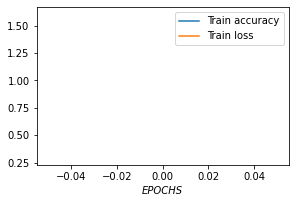

In [13]:
list1 = [0] * EPOCHS
for i in range(EPOCHS):
  list1[i] = i
font = FontProperties()
font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
fig, ax = plt.subplots(figsize=(5, 3))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.plot(list1, train_acc, label = 'Train accuracy')
ax.plot(list1, train_loss, label = 'Train loss')
ax.set_xlabel('EPOCHS', fontproperties=font)
plt.legend(loc='upper right')
plt.show()

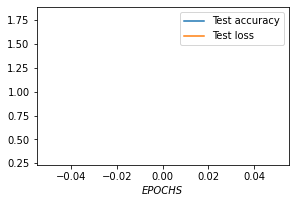

In [14]:
font = FontProperties()
font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
fig, ax = plt.subplots(figsize=(5, 3))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.plot(list1, test_acc, label = 'Test accuracy')
ax.plot(list1, test_loss, label = 'Test loss')
ax.set_xlabel('EPOCHS', fontproperties=font)
plt.legend(loc='upper right')
plt.show()

In [15]:
correct = 0
total = 0
ind = 0
net.eval()
with torch.no_grad():
    for i in tqdm(range(0, len(X_train), batch_size)):
        real_class = y_train[i:i + batch_size]
        batch_X = X_train[i:i + batch_size].view(-1, 1, 48, 48).cuda()
        ans = net(batch_X)
        for j in range(len(ans)):
            ind = torch.argmax(ans[j])
            if (real_class[j] == ind):
                correct += 1
            total += 1
print("Accuracy on train: ", round(correct/total, 3))
net.train()

100%|██████████| 1615/1615 [00:18<00:00, 88.05it/s]

Accuracy on train:  0.294


SmallNet(
  (features1): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (features2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (features3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=18432, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): L

In [16]:
correct = 0
total = 0
ind = 0
net.eval()
with torch.no_grad():
    for i in tqdm(range(0, len(X_test), batch_size)):
        real_class = y_test[i:i + batch_size]
        batch_X = X_test[i:i + batch_size].view(-1, 1, 48, 48).cuda()
        ans = net(batch_X)
        for j in range(len(ans)):
            ind = torch.argmax(ans[j])
            if (real_class[j] == ind):
                correct += 1
            total += 1
print("Accuracy on test: ", round(correct/total, 3))
net.train()

100%|██████████| 36/36 [00:00<00:00, 79.94it/s]

Accuracy on test:  0.31


SmallNet(
  (features1): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (features2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (features3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=18432, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): L

In [83]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [0]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [88]:
while(True):
  PATH = 0
  while(not(PATH)):
    print('Input image name to save without .jpg')
    PATH = input()
  PATH += '.jpg'
  if (os.path.exists(PATH)):
    break
  print('No image ' + PATH)
img = image.load_img(PATH, grayscale=True, target_size=(48, 48))
show_img=image.load_img(PATH, grayscale=False, target_size=(200, 200))
a = image.img_to_array(img)
a = np.expand_dims(a, axis = 0)

a /= 255

x = [a, a]

x = torch.Tensor(x).view(-1, 1, 48, 48).cuda()

net.eval()
custom = net(x)
net.train()

custom = custom.cpu().detach().numpy()

emotion_analysis(custom[0])

x = x[0].cpu().detach().numpy()

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

Input image name to save without .jpg

Input image name to save without .jpg
1
No image 1.jpg
Input image name to save without .jpg


KeyboardInterrupt: ignored